In [37]:
import os
import pickle
import numpy as np
import pandas as pd
from numpy import nan as Nan
from numpy import inf as inf
from tqdm import notebook as tqdm
from scipy.sparse import csr_matrix
from sklearn.model_selection import cross_val_predict
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import SelectFromModel

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from data_preprocessing import *
from utils import bootstrap_roc_auc

from training_functions import *
from merging import *
from utils import *
from model_evaluation import ModelEvaluation

LogisticRegression

In [68]:
df_mpdb_plane, cnt_and_name_features_mpdb = get_featurizers_features_mpdb()

X_mpdb = df_mpdb_plane.drop([ 
     'formula_pretty',
     'material_id', 
 ], axis=1)


df_kahle_fin, cnt_and_name_features_kahle = get_featurizers_features_kahle()

X_kahle = df_kahle_fin.drop([ 
    'stru_label',
     'stru_id', 
     'group', 
     'structure', 
     'diffusion_mean_cm2_s', 
     'label', 
     'src_id', 
     'diffusion_sem_cm2_s', 
     'n_Li', 
     'sigma_S_cm', 
     'sigma_S_cm_sem', 
     'sigma_S_cm_err'
 ], axis=1)


In [69]:
feature_names = X_kahle.columns.tolist()
feature_names = np.array(feature_names)[~np.all(X_kahle.to_numpy() == 0, axis=0)]

X_kahle = X_kahle.to_numpy()
X_mpdb = X_mpdb.to_numpy()

X_mpdb = X_mpdb[:, ~np.all(X_kahle == 0, axis=0)]

X_kahle = X_kahle[:, ~np.all(X_kahle == 0, axis=0)]

scaler = StandardScaler()

X_mpdb = scaler.fit_transform(X_mpdb)
X_kahle = scaler.transform(X_kahle)

feature_weights = [1 / cnt_and_name_features_kahle['_'.join(x.split('_')[1:])] for x in feature_names]
feature_names = np.array(list(map(lambda x: x.split('_')[0] + '_' + featurizers_mapping['_'.join(x.split('_')[1:])], feature_names)))


In [71]:
params = {
        "max_iter": 300,
    }

pipeline = ModelEvaluation(df_kahle_fin, model_name = 'logreg', params = params)
pipeline.fit(X_kahle, np.ones(X_kahle.shape[1]), thr_positive = 1e-1, thr_negative = 1e-2, feature_names = feature_names)
pipeline.evaluate(num_of_evaluations = 1, X_mpdb = X_mpdb)

  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.9933463161311263


100%|██████████| 1/1 [00:42<00:00, 42.66s/it]

test roc-auc mean: 0.6717848191300577, std: 0.060105504738683466
mean train roc-auc: 0.9936168553597632


In [72]:
pipeline.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.993617
1,roc_auc on test by aggregated preds,0.670841
2,mean test roc-auc averaged by 40 models,0.671785
3,roc_like_comparison by aggregated preds,39.740112
4,roc_like_comparison averaged by 40 models,39.740112
5,roc_like_comparison std,0.000000


In [73]:
df_kahle_fin_nn = get_nn_features_kahle()


X_kahle_nn = df_kahle_fin_nn.drop([ 
    'src_id',
    'diffusion_mean_cm2_s',
    'stru_label', 
    'stru_id', 
    'structure', 
    'group', 
    'label', 
    'diffusion_sem_cm2_s', 
    'n_Li', 
    'sigma_S_cm', 
    'sigma_S_cm_sem', 
    'sigma_S_cm_err'
 ], axis=1)

df_mpdb_nn = get_nn_features_mpdb()

X_mpdb_nn = df_mpdb_nn.drop([ 
    'material_id',
 ], axis=1)

In [74]:
feature_names_nn = X_kahle_nn.columns.tolist()
feature_names_nn = np.array(feature_names_nn)

X_kahle_nn = X_kahle_nn.to_numpy()
X_mpdb_nn = X_mpdb_nn.to_numpy()

scaler = StandardScaler().fit(X_mpdb_nn)

X_mpdb_nn = scaler.transform(X_mpdb_nn)
X_kahle_nn = scaler.transform(X_kahle_nn)

In [75]:
params = {
        "max_iter": 300,
    }

pipeline_nn = ModelEvaluation(df_kahle_fin_nn, model_name = 'logreg', params = params)
pipeline_nn.fit(X_kahle_nn, np.ones(X_kahle_nn.shape[1]), thr_positive = 1e-1, thr_negative = 1e-2, feature_names = feature_names_nn)
pipeline_nn.evaluate(num_of_evaluations = 1, X_mpdb = X_mpdb_nn)

  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8296007789678675


100%|██████████| 1/1 [00:05<00:00,  5.88s/it]

test roc-auc mean: 0.7058142313066605, std: 0.05544170395411622
mean train roc-auc: 0.832450683757984


In [76]:
pipeline_nn.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.832451
1,roc_auc on test by aggregated preds,0.706376
2,mean test roc-auc averaged by 40 models,0.705814
3,roc_like_comparison by aggregated preds,56.667571
4,roc_like_comparison averaged by 40 models,56.667571
5,roc_like_comparison std,0.000000


In [77]:
df_kahle_fin['src_id'].to_list() == df_kahle_fin_nn['src_id'].to_list()

True

In [78]:
X_kahle_merged = np.concatenate([X_kahle, X_kahle_nn], axis = 1)
X_mpdb_merged = np.concatenate([X_mpdb, X_mpdb_nn], axis = 1)

feature_names_merged = np.concatenate([feature_names, feature_names_nn], axis = 0)
# feature_weights_merged = np.concatenate([feature_weights, feature_weights_nn], axis = 0)

In [79]:
params = {
        "max_iter": 300,
    }

pipeline_merged = ModelEvaluation(df_kahle_fin_nn, model_name = 'logreg', params = params)
pipeline_merged.fit(X_kahle_merged, np.ones(X_kahle_nn.shape[1]), thr_positive = 1e-1, thr_negative = 1e-2, feature_names = feature_names_merged)
pipeline_merged.evaluate(num_of_evaluations = 1, X_mpdb = X_mpdb_merged)

  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.9938331710483609


100%|██████████| 1/1 [00:42<00:00, 42.07s/it]

test roc-auc mean: 0.7110051854524797, std: 0.06115095038300649
mean train roc-auc: 0.9936168452353603


In [80]:
pipeline_merged.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.993617
1,roc_auc on test by aggregated preds,0.711966
2,mean test roc-auc averaged by 40 models,0.711005
3,roc_like_comparison by aggregated preds,55.606795
4,roc_like_comparison averaged by 40 models,55.606795
5,roc_like_comparison std,0.000000


In [81]:
def plot_feature_importance(axs, feature_importance, feature_names, title):
    idx = np.argsort(feature_importance)[-50:]
    axs.xaxis.set_tick_params(rotation=90)
    axs.set_title(title)
    axs.set_ylabel('importance')
    axs.set_xlabel('feature names');
    axs.bar(feature_names[idx], feature_importance[idx])

In [82]:
def plot_distribution(df, axs, preds, title):

    df['preds'] = preds
    
    A = df[df['group'] == 'A']
    B1 = df[df['group'] == 'B1']
    B2 = df[df['group'] == 'B2']
    C = df[df['group'] == 'C']

    axs.scatter(np.log10(A['sigma_S_cm']).to_list(), A['preds'].to_list(), label='A', c = 'pink')
    axs.scatter(np.log10(B1['sigma_S_cm']).to_list(), B1['preds'].to_list(), label='B1', c = 'purple')
    axs.scatter(np.log10(B2['sigma_S_cm']).to_list(), B2['preds'].to_list(), label='B2', c = 'lightblue')
    axs.scatter(np.log10(C['sigma_S_cm']).to_list(), C['preds'].to_list(), label='C', c = 'lightgreen')

    axs.set_ylabel('probability')
    axs.set_xlabel('np.log10(sigma_S_cm)')

    axs.set_title(title);
    axs.legend();


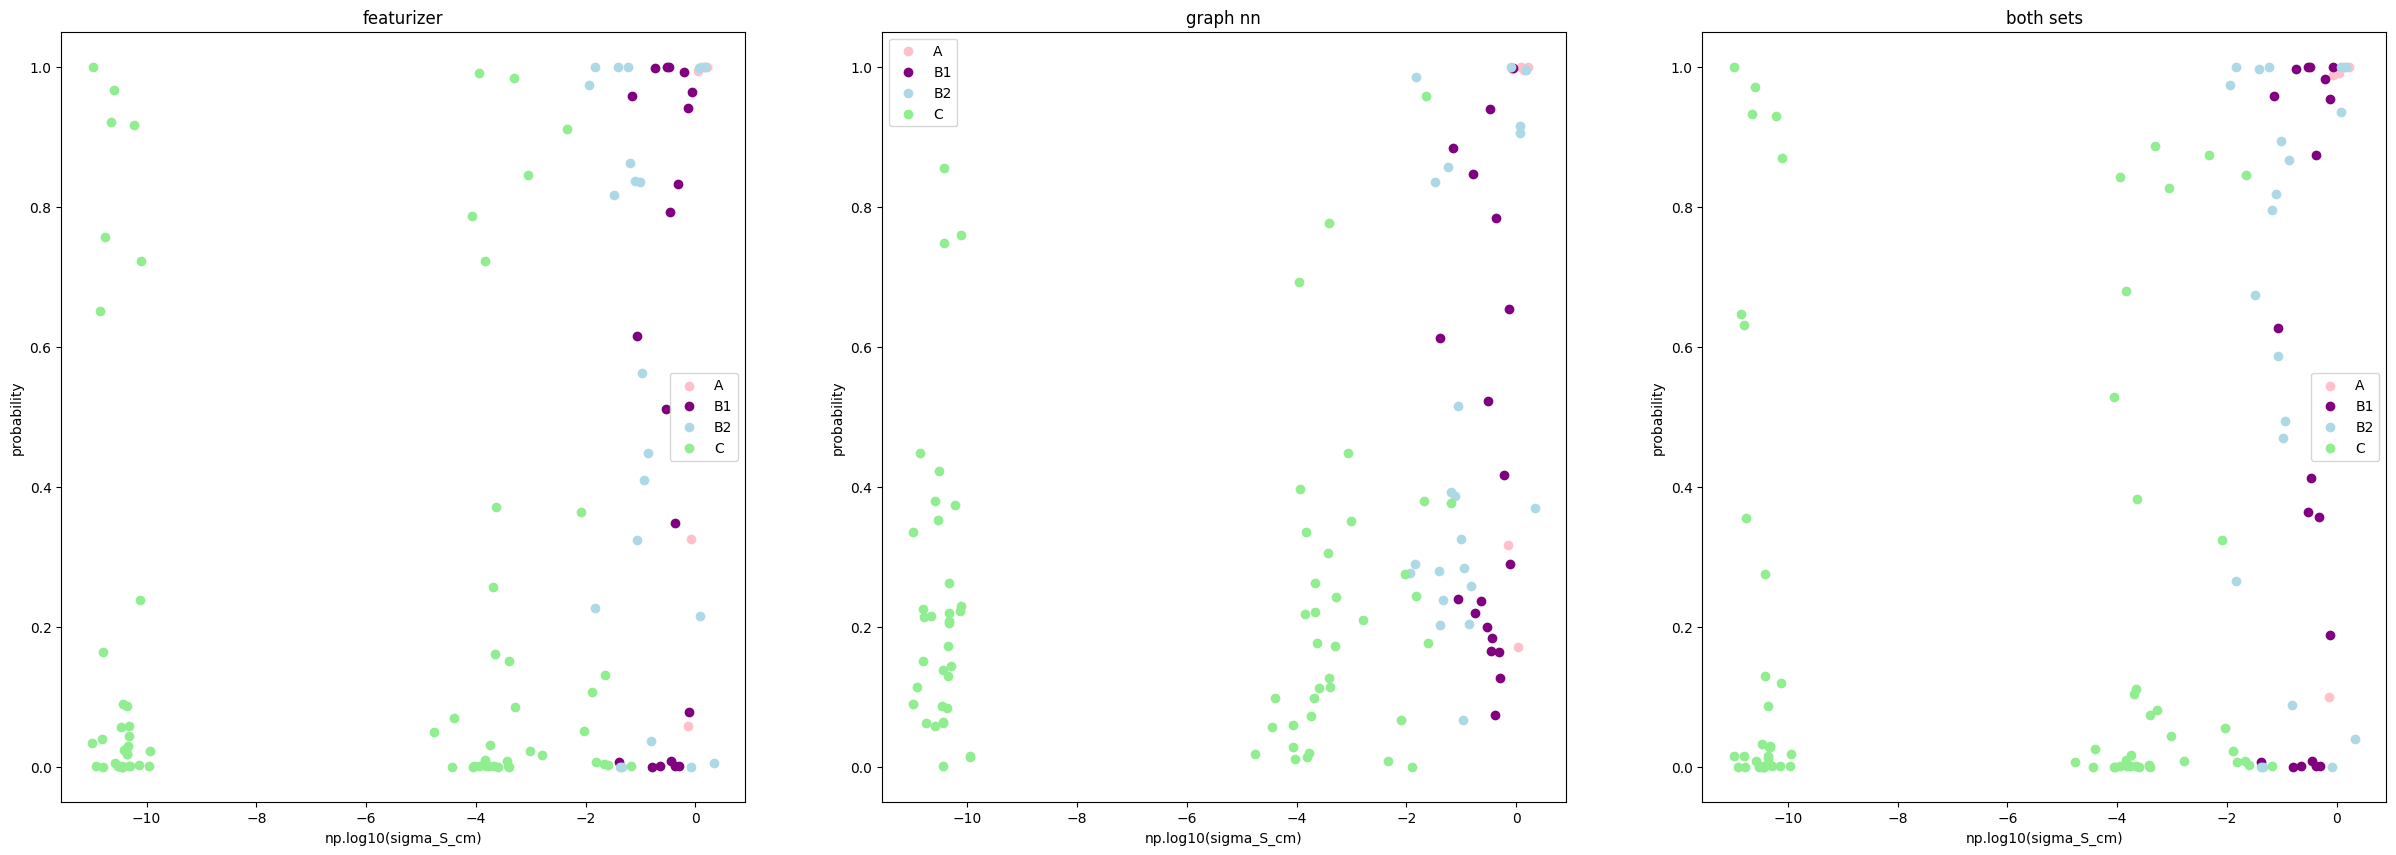

In [94]:
fig, axs = plt.subplots(1, 3, figsize=(30, 10))

plot_distribution(df_kahle_fin, axs[0], pipeline.preds_kahle[0], 'featurizer')
plot_distribution(df_kahle_fin, axs[1], pipeline_nn.preds_kahle[0], 'graph nn')
plot_distribution(df_kahle_fin, axs[2], pipeline_merged.preds_kahle[0], 'both sets')


In [88]:
def plot_feature_importance(axs, feature_importance, feature_names, title):
    idx = np.argsort(feature_importance)[-50:]
    axs.xaxis.set_tick_params(rotation=90)
    axs.set_title(title)
    axs.set_ylabel('importance')
    axs.set_xlabel('feature names');

    axs.bar(feature_names[idx], feature_importance[idx])

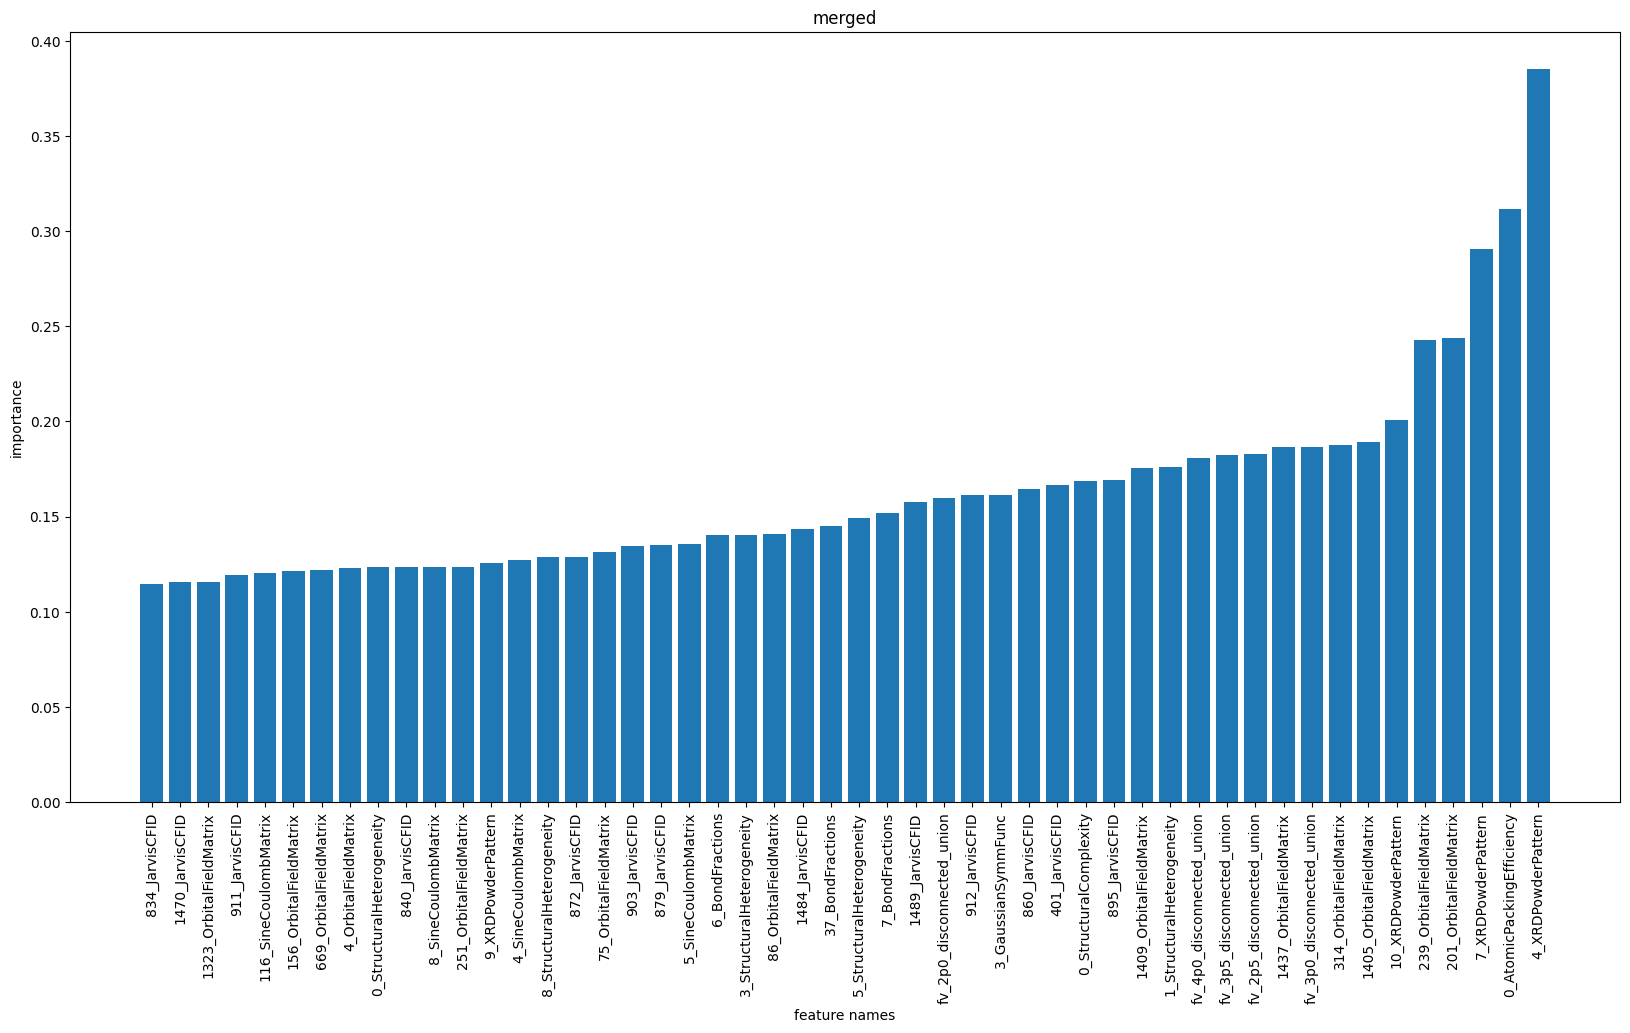

In [98]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

plot_feature_importance(axs, np.abs(pipeline_merged.feature_importance), pipeline_merged.feature_names, 'merged')


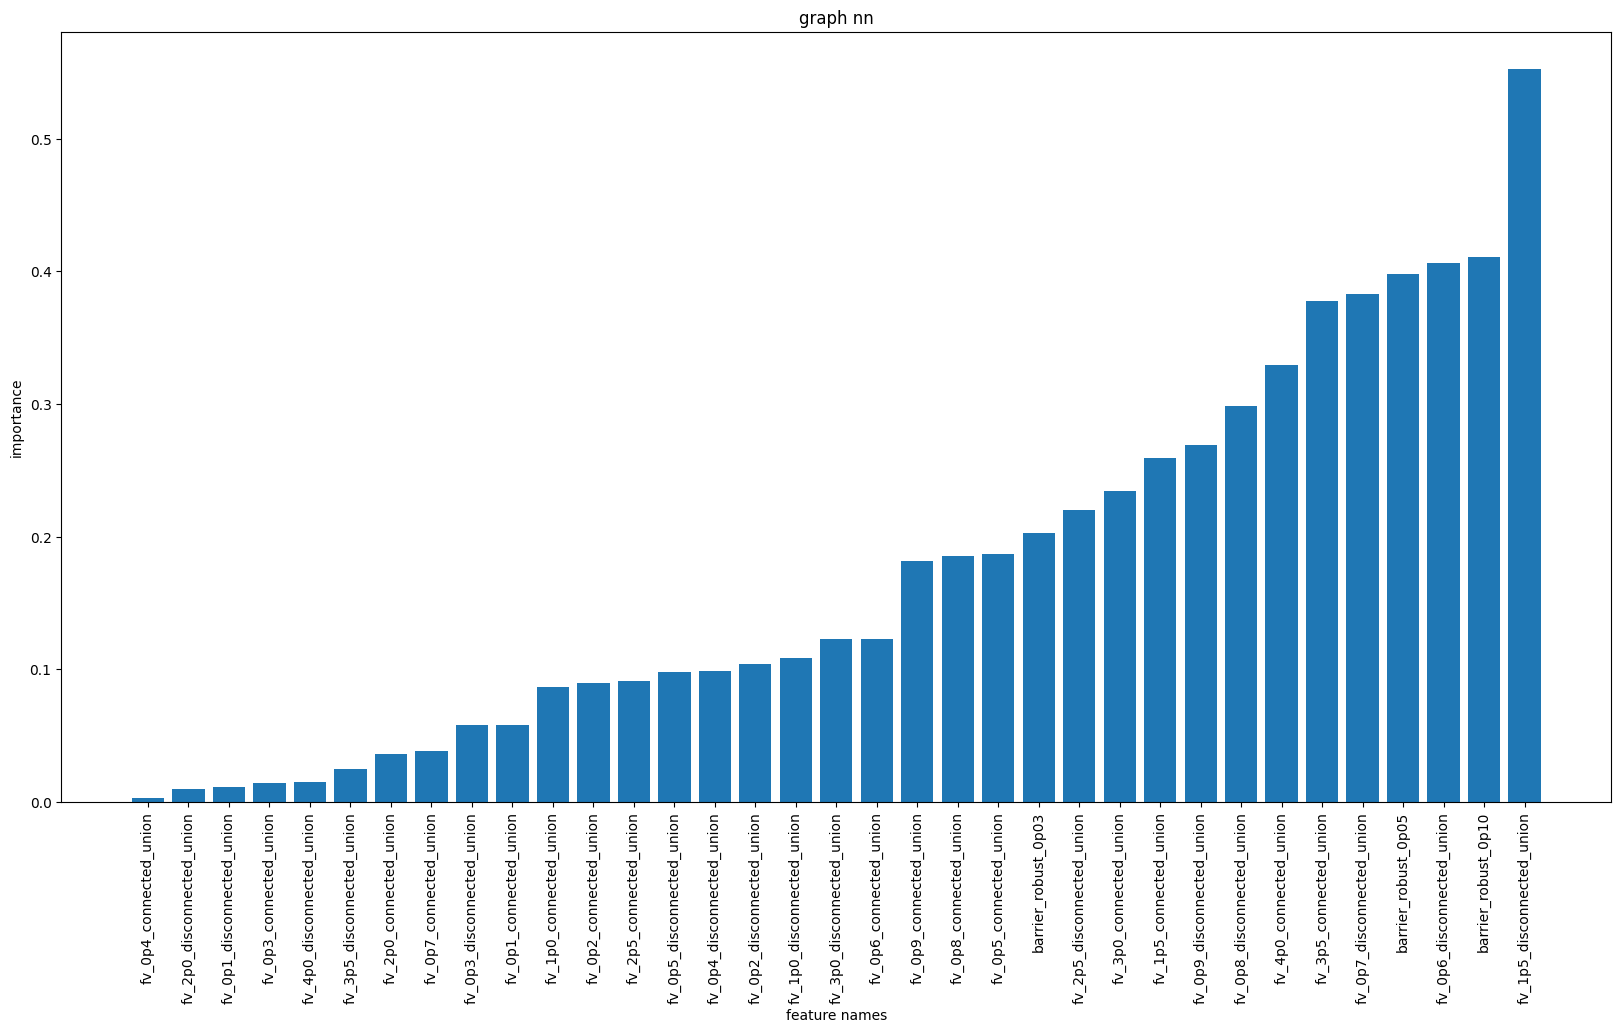

In [96]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

plot_feature_importance(axs, np.abs(pipeline_nn.feature_importance), pipeline_nn.feature_names, 'graph nn')


In [112]:
params = {
        "max_iter": 300,
    }

model_class = LogisticRegression(**params, verbose = False, random_state = 42)

y = df_kahle_fin['sigma_S_cm'] >= 1e-1
preds, model = train_simple_loop(X_kahle, y, model_class)

print(roc_auc_score(y, preds))
print('ROClikeComparison:', calculate_ROClikeComparisonMetrics(df_kahle_fin, preds)['score']['preds'])

100%|██████████| 116/116 [00:28<00:00,  4.09it/s]


0.618378849423156 0.0605490239351565
mean train roc-auc 1.0
0.618595825426945
ROClikeComparison: 23.186550197209428


In [120]:
X_kahle.shape

(116, 2093)

In [110]:
params = {
        "max_iter": 300,
    }

model_class = LogisticRegression(**params, verbose = False, random_state = 42)

y = df_kahle_fin['sigma_S_cm'] >= 1e-1
preds, model = train_simple_loop(X_kahle_nn, y, model_class)

print(roc_auc_score(y, preds))
print('ROClikeComparison:', calculate_ROClikeComparisonMetrics(df_kahle_fin, preds)['score']['preds'])

100%|██████████| 116/116 [00:01<00:00, 68.89it/s]


0.6752497454668098 0.05930329307614014
mean train roc-auc 0.6680563604752244
0.6777988614800758
ROClikeComparison: 52.56469340738732


In [111]:
params = {
        "max_iter": 300,
    }

model_class = LogisticRegression(**params, verbose = False, random_state = 42)

y = df_kahle_fin['sigma_S_cm'] >= 1e-1
preds, model = train_simple_loop(X_kahle_merged, y, model_class)

print(roc_auc_score(y, preds))
print('ROClikeComparison:', calculate_ROClikeComparisonMetrics(df_kahle_fin, preds)['score']['preds'])

100%|██████████| 116/116 [00:27<00:00,  4.16it/s]


0.6559448964536233 0.061236469605271994
mean train roc-auc 1.0
0.6535104364326376
ROClikeComparison: 32.22177353367769


In [130]:
np.logspace(-5, -2, 6)

array([1.00000000e-05, 3.98107171e-05, 1.58489319e-04, 6.30957344e-04,
       2.51188643e-03, 1.00000000e-02])

In [125]:
for c in np.logspace(-5, -2, 6):
    params = {
        "max_iter": 300,
    }
    params['C'] = c

    pipeline = ModelEvaluation(df_kahle_fin, model_name = 'logreg', params = params)
    pipeline.fit(X_kahle, np.ones(X_kahle.shape[1]), thr_positive = 1e-1, thr_negative = 1e-2, feature_names = feature_names)
    pipeline.evaluate(num_of_evaluations = 1, X_mpdb = X_mpdb)

    print(pipeline.show_results())

  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8140214216163584


100%|██████████| 1/1 [00:09<00:00,  9.86s/it]

test roc-auc mean: 0.4815750721645228, std: 0.06739511861925238
mean train roc-auc: 0.8162246007266891


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.816225
1        roc_auc on test by aggregated preds   0.481382
2    mean test roc-auc averaged by 40 models   0.481575
3    roc_like_comparison by aggregated preds  17.742207
4  roc_like_comparison averaged by 40 models  17.742207
5                    roc_like_comparison std   0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.820350535540409


100%|██████████| 1/1 [00:13<00:00, 13.10s/it]

test roc-auc mean: 0.6578414087509753, std: 0.062189432025463925
mean train roc-auc: 0.8236024900287519


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.823602
1        roc_auc on test by aggregated preds   0.651685
2    mean test roc-auc averaged by 40 models   0.657841
3    roc_like_comparison by aggregated preds  31.986236
4  roc_like_comparison averaged by 40 models  31.986236
5                    roc_like_comparison std   0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8328464784160987


100%|██████████| 1/1 [00:15<00:00, 15.53s/it]

test roc-auc mean: 0.7113408874203431, std: 0.056838736660241335
mean train roc-auc: 0.8360092134458256


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.836009
1        roc_auc on test by aggregated preds   0.710275
2    mean test roc-auc averaged by 40 models   0.711341
3    roc_like_comparison by aggregated preds  37.855954
4  roc_like_comparison averaged by 40 models  37.855954
5                    roc_like_comparison std   0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8674131775397598


100%|██████████| 1/1 [00:12<00:00, 12.46s/it]

test roc-auc mean: 0.725827171401322, std: 0.05688097709765863
mean train roc-auc: 0.8697078720471348


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.869708
1        roc_auc on test by aggregated preds   0.724049
2    mean test roc-auc averaged by 40 models   0.725827
3    roc_like_comparison by aggregated preds  44.460945
4  roc_like_comparison averaged by 40 models  44.460945
5                    roc_like_comparison std   0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.9112301200908797


100%|██████████| 1/1 [00:15<00:00, 15.95s/it]

test roc-auc mean: 0.7002722874034998, std: 0.05944531515580935
mean train roc-auc: 0.9126858058008483


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.912686
1        roc_auc on test by aggregated preds   0.700739
2    mean test roc-auc averaged by 40 models   0.700272
3    roc_like_comparison by aggregated preds  39.730721
4  roc_like_comparison averaged by 40 models  39.730721
5                    roc_like_comparison std   0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.9532619279454723
test roc-auc mean: 0.695648101537042, std: 0.06277484217451693
mean train roc-auc: 0.9540923167343199


100%|██████████| 1/1 [00:18<00:00, 18.16s/it]


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.954092
1        roc_auc on test by aggregated preds   0.692074
2    mean test roc-auc averaged by 40 models   0.695648
3    roc_like_comparison by aggregated preds  38.771529
4  roc_like_comparison averaged by 40 models  38.771529
5                    roc_like_comparison std   0.000000


In [127]:
for c in np.logspace(-5, -2, 6):
    params = {
        "max_iter": 300,
    }
    params['C'] = c

    pipeline = ModelEvaluation(df_kahle_fin, model_name = 'logreg', params = params)
    pipeline.fit(X_kahle_merged, np.ones(X_kahle.shape[1]), thr_positive = 1e-1, thr_negative = 1e-2, feature_names = feature_names_merged)
    pipeline.evaluate(num_of_evaluations = 1, X_mpdb = X_mpdb_merged)

    print(pipeline.show_results())

  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8263550795196366


100%|██████████| 1/1 [00:10<00:00, 10.29s/it]

test roc-auc mean: 0.5299752616959609, std: 0.06590633129373749
mean train roc-auc: 0.8305107961845065


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.830511
1        roc_auc on test by aggregated preds   0.528685
2    mean test roc-auc averaged by 40 models   0.529975
3    roc_like_comparison by aggregated preds  25.531337
4  roc_like_comparison averaged by 40 models  25.531337
5                    roc_like_comparison std   0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8286270691333983


100%|██████████| 1/1 [00:11<00:00, 11.17s/it]

test roc-auc mean: 0.6907496942194984, std: 0.0604972714779752
mean train roc-auc: 0.8350042877766135


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.835004
1        roc_auc on test by aggregated preds   0.692391
2    mean test roc-auc averaged by 40 models   0.690750
3    roc_like_comparison by aggregated preds  35.753617
4  roc_like_comparison averaged by 40 models  35.753617
5                    roc_like_comparison std   0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.846965271015904


100%|██████████| 1/1 [00:10<00:00, 10.59s/it]

test roc-auc mean: 0.7356383504595897, std: 0.057059166216324356
mean train roc-auc: 0.8493026292963547


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.849303
1        roc_auc on test by aggregated preds   0.738496
2    mean test roc-auc averaged by 40 models   0.735638
3    roc_like_comparison by aggregated preds  46.975410
4  roc_like_comparison averaged by 40 models  46.975410
5                    roc_like_comparison std   0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.8781239857189225


100%|██████████| 1/1 [00:12<00:00, 12.09s/it]

test roc-auc mean: 0.7493669282290578, std: 0.05563452147214521
mean train roc-auc: 0.8798933590213361


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.879893
1        roc_auc on test by aggregated preds   0.751339
2    mean test roc-auc averaged by 40 models   0.749367
3    roc_like_comparison by aggregated preds  53.064837
4  roc_like_comparison averaged by 40 models  53.064837
5                    roc_like_comparison std   0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.921616358325219


100%|██████████| 1/1 [00:14<00:00, 14.85s/it]

test roc-auc mean: 0.7359484589680686, std: 0.05750997023154722
mean train roc-auc: 0.9222150170222505


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.922215
1        roc_auc on test by aggregated preds   0.739873
2    mean test roc-auc averaged by 40 models   0.735948
3    roc_like_comparison by aggregated preds  52.789867
4  roc_like_comparison averaged by 40 models  52.789867
5                    roc_like_comparison std   0.000000


  0%|          | 0/1 [00:00<?, ?it/s]

roc-auc on train for 0 fold with size 118: 0.9579681921454073


100%|██████████| 1/1 [00:15<00:00, 15.46s/it]

test roc-auc mean: 0.7168515764570089, std: 0.059773795924929776
mean train roc-auc: 0.9584411260088324


                                   statistic     result
0   mean train roc-auc averaged by 40 models   0.958441
1        roc_auc on test by aggregated preds   0.720093
2    mean test roc-auc averaged by 40 models   0.716852
3    roc_like_comparison by aggregated preds  52.818030
4  roc_like_comparison averaged by 40 models  52.818030
5                    roc_like_comparison std   0.000000


In [117]:
pipeline.show_results()

,statistic,result
0,mean train roc-auc averaged by 40 models,0.870934
1,roc_auc on test by aggregated preds,0.725965
2,mean test roc-auc averaged by 40 models,0.725379
3,roc_like_comparison by aggregated preds,43.460945
4,roc_like_comparison averaged by 40 models,43.460945
5,roc_like_comparison std,0.000000


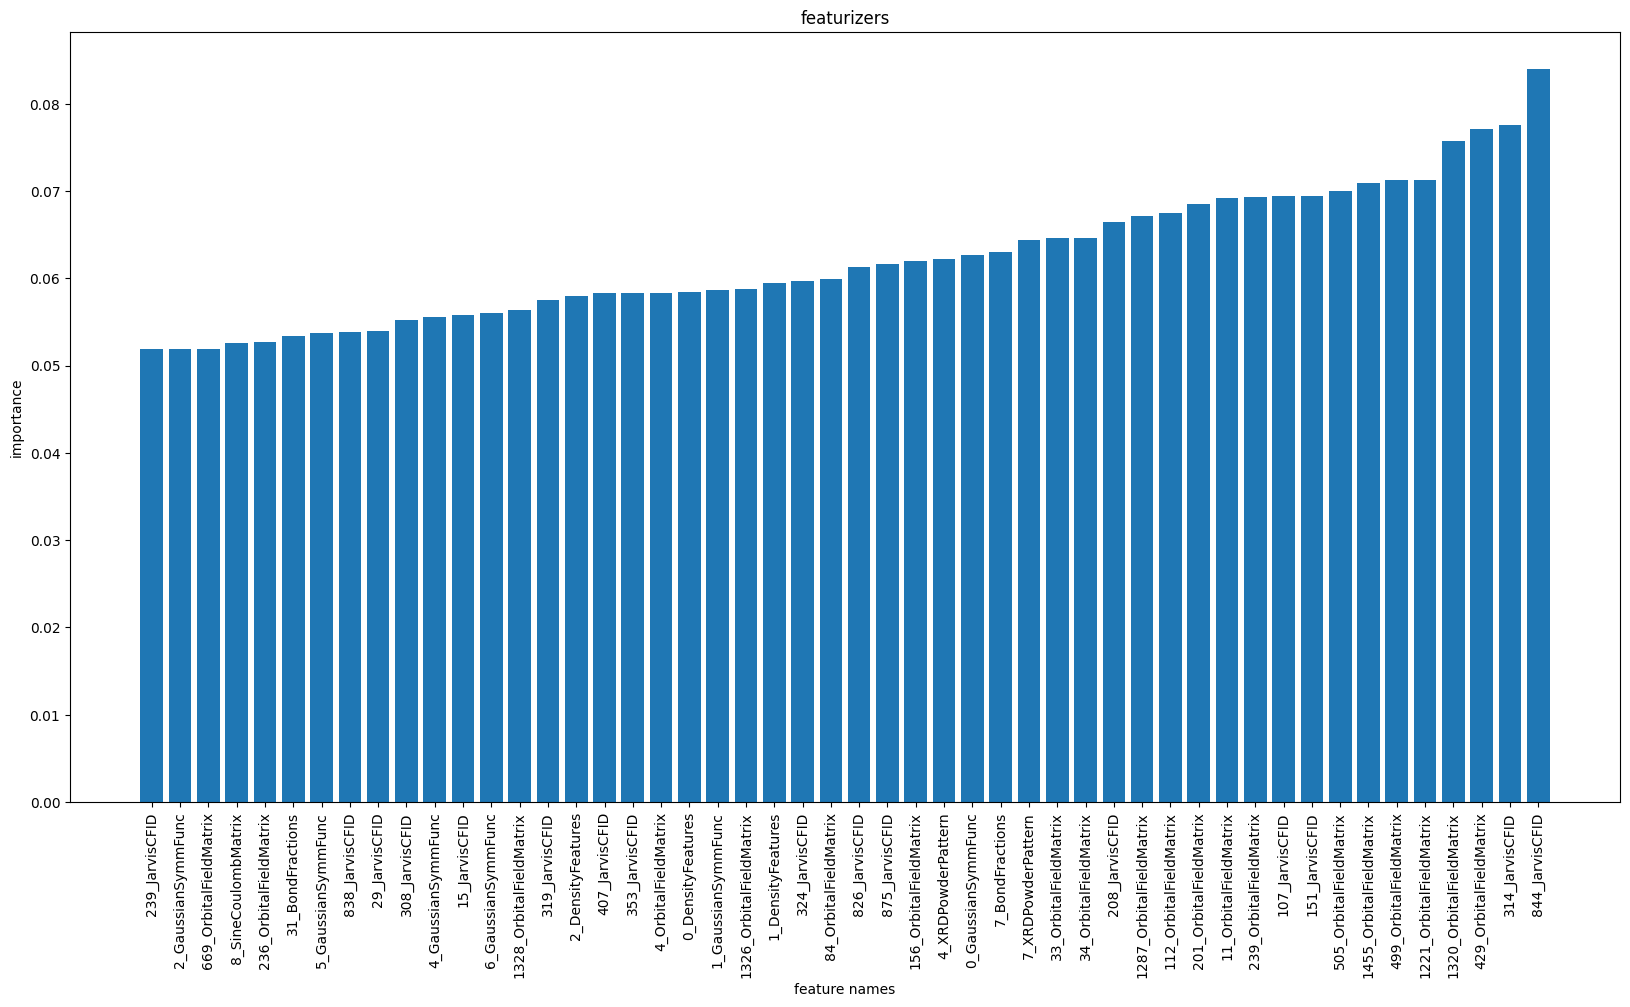

In [121]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))

plot_feature_importance(axs, np.abs(pipeline.feature_importance), pipeline.feature_names, 'featurizers')
